# HW 3 - Tushar Jain

## Module imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from pandas.plotting import scatter_matrix, lag_plot, autocorrelation_plot

In [2]:
%matplotlib inline

## Data ingestion

In [3]:
df = pd.read_csv('data/hw3.csv')
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,NaN,UNI,ETH
1,2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,NaN,CRV,ETH
2,2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,NaN,SOL,SOL
3,2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,NaN,ETH,ETH
4,2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,NaN,SOL,SOL


In [4]:
df['ts'] = pd.to_datetime(df['ts'])
df = df.set_index('ts')

## Clean Up

### Drop duplicates

In [5]:
df = df.drop_duplicates()

### Fix the token column

In [6]:
df.token.unique()

array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC',
       '<span name="tokenName">UNI</span>',
       '<span name="tokenName">CRV</span>',
       '<span name="tokenName">SOL</span>',
       '<span name="tokenName">USDT</span>',
       '<span name="tokenName">COMP</span>',
       '<span name="tokenName">AAVE</span>',
       '<span name="tokenName">ETH</span>',
       '<span name="tokenName">BTC</span>'], dtype=object)

In [7]:
df['token'] = df['token'].mask(df['token'].str.contains('span'), df['token'].str.extract(r'<span.*?>(.*?)</span>', expand=False))
df['token'].unique()

array(['UNI', 'CRV', 'SOL', 'ETH', 'AAVE', 'USDT', 'COMP', 'BTC'],
      dtype=object)

### Fixing close price

#### 1. Cleaning up outliers

In [8]:
def create_graphs(df, column):
    fig, axes = plt.subplots(nrows=math.ceil(df.token.nunique()/2.0), 
                             ncols=2, 
                             figsize=(10, 6*(math.ceil(df.token.nunique()/2.0))))

    for idx, (token, df_token) in enumerate(df[['token', column]].groupby('token')):
        ax = axes[idx//2, idx%2]
        df_token[column].plot(ax=ax, label=f'{token}_{column}')
        ax.legend()

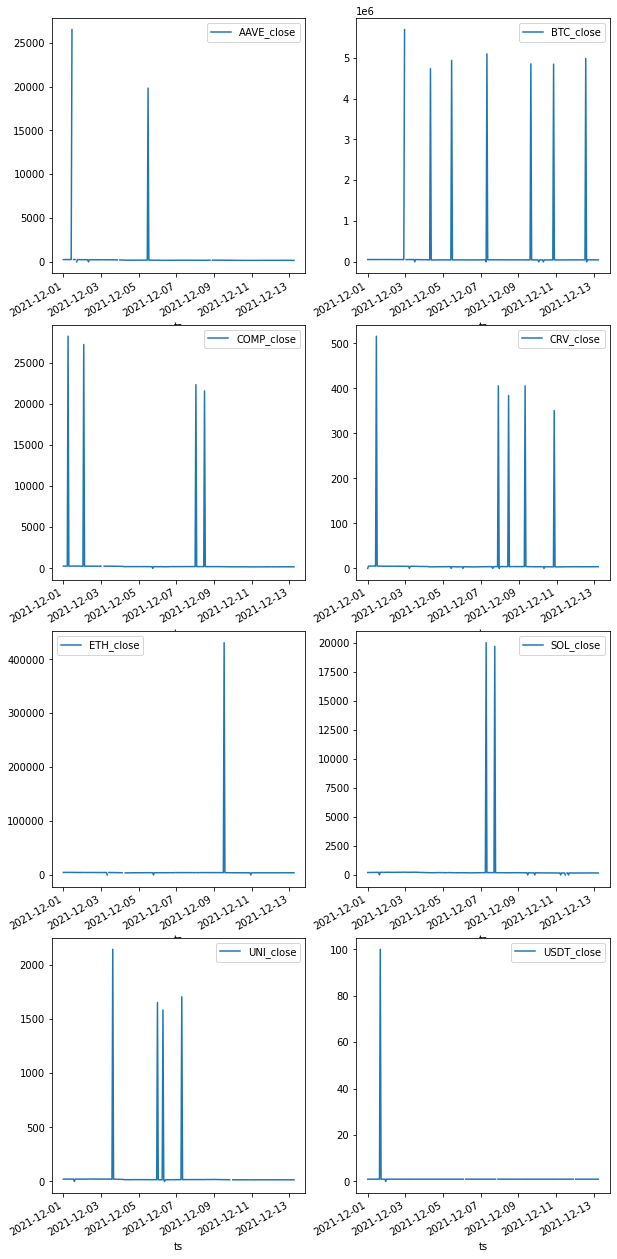

In [9]:
create_graphs(df, 'close')

In [10]:
df['close'] = df['close'].mask(df['close']/df['open'] > 2, 0.5 * (df['high'] + df['low']))

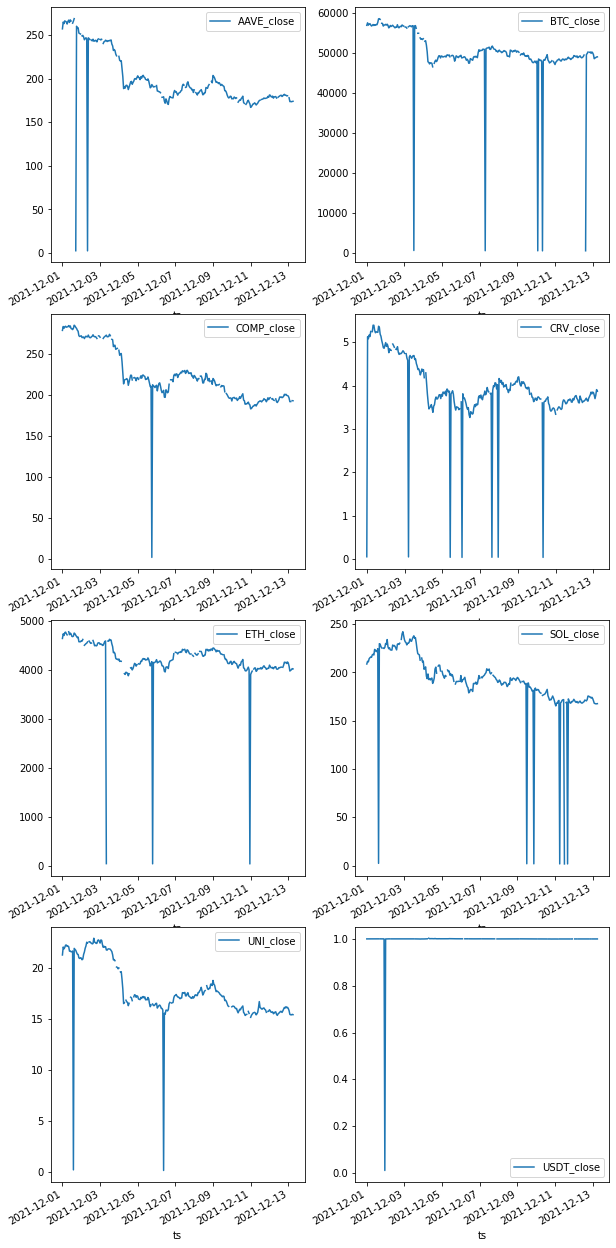

In [11]:
create_graphs(df, 'close')

In [12]:
df['close'] = df['close'].mask(df['close']/df['open'] < 0.5, 0.5 * (df['high'] + df['low']))

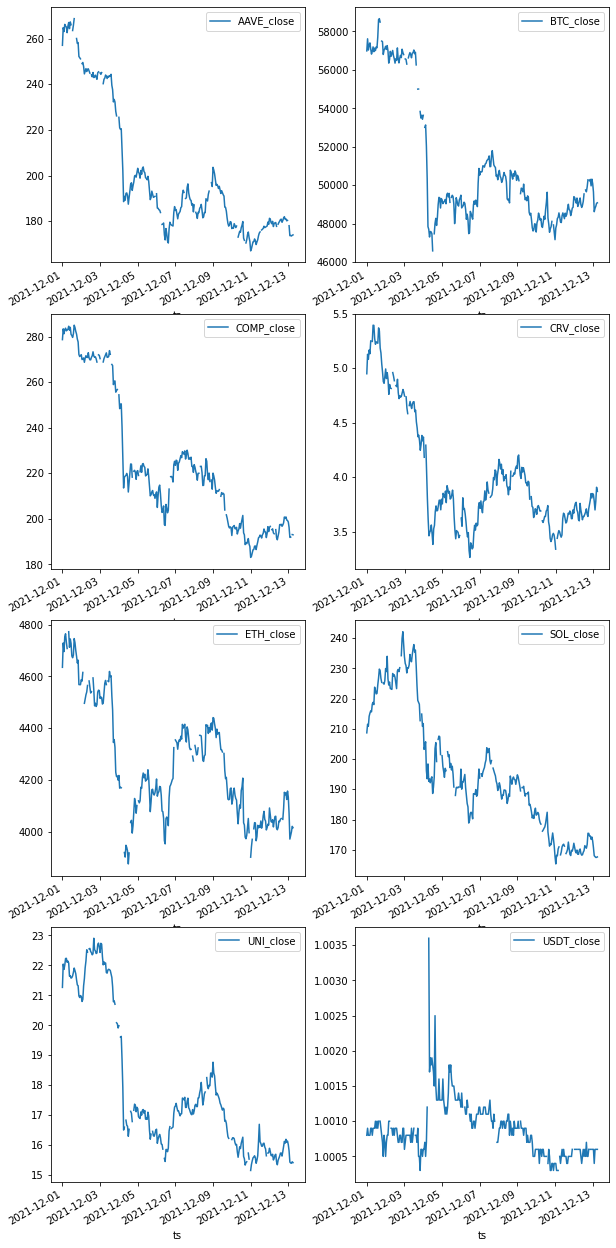

In [13]:
create_graphs(df, 'close')

#### 2. Cleaning up NaNs

In [14]:
df.loc[df['close'].isnull()]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-05 16:00:00,190.8120,NaN,181.5000,NaN,2.511136e+05,NaN,SOL,SOL
2021-12-08 06:00:00,4323.3300,4346.9700,4312.1300,NaN,6.318514e+03,NaN,ETH,ETH
2021-12-13 04:00:00,191.8500,192.8700,191.1900,NaN,1.046025e+03,NaN,COMP,ETH
2021-12-10 07:00:00,178.4900,NaN,176.7300,NaN,3.951398e+04,NaN,SOL,SOL
2021-12-06 03:00:00,1.0012,1.0014,1.0011,NaN,5.582397e+06,NaN,USDT,USDT
...,...,...,...,...,...,...,...,...
2021-12-10 06:00:00,3.6800,NaN,3.6400,NaN,6.203307e+04,NaN,CRV,ETH
2021-12-02 12:00:00,4.8899,4.9221,4.8024,NaN,9.454392e+04,NaN,CRV,ETH
2021-12-06 09:00:00,15.8728,NaN,15.6670,NaN,1.543971e+05,NaN,UNI,ETH


##### 1. If high and low are available, set close as average of those

In [15]:
df['close'] = df['close'].mask(df['close'].isnull(), 0.5*(df['high'] + df['low']))
df.loc[df['close'].isnull()]

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-05 16:00:00,190.8120,NaN,181.5000,NaN,2.511136e+05,NaN,SOL,SOL
2021-12-10 07:00:00,178.4900,NaN,176.7300,NaN,3.951398e+04,NaN,SOL,SOL
2021-12-12 14:00:00,49542.3900,NaN,49534.7100,NaN,3.426704e+02,NaN,BTC,BTC
2021-12-11 13:00:00,170.2400,NaN,169.8600,NaN,2.604478e+04,NaN,SOL,SOL
2021-12-04 08:00:00,16.5753,NaN,16.1110,NaN,1.143725e+05,NaN,UNI,ETH
2021-12-09 03:00:00,1.0009,NaN,1.0008,NaN,3.815993e+06,NaN,USDT,USDT
2021-12-10 23:00:00,3996.1700,NaN,3953.7700,NaN,8.379371e+03,NaN,ETH,ETH
2021-12-02 14:00:00,4540.3000,4546.3000,NaN,NaN,4.468941e+03,NaN,ETH,ETH
2021-12-01 17:00:00,265.2620,NaN,262.9060,NaN,9.809190e+02,NaN,AAVE,ETH


##### 2. Remove all other entries with close as NaN

In [18]:
df.dropna(subset=['close'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2316 entries, 2021-12-02 14:00:00 to 2021-12-06 07:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       2316 non-null   float64
 1   high       1899 non-null   float64
 2   low        2073 non-null   float64
 3   close      2316 non-null   float64
 4   volume     2316 non-null   float64
 5   volumeUSD  0 non-null      float64
 6   token      2316 non-null   object 
 7   chain      2316 non-null   object 
dtypes: float64(6), object(2)
memory usage: 162.8+ KB


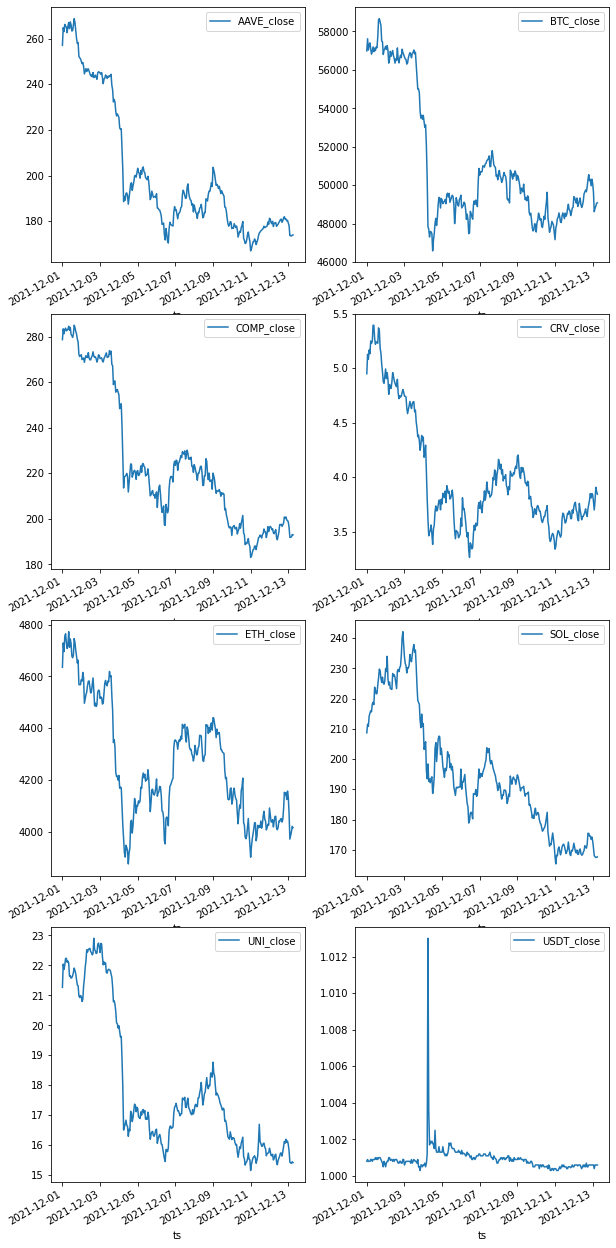

In [19]:
create_graphs(df, 'close')

### Fixing Volume

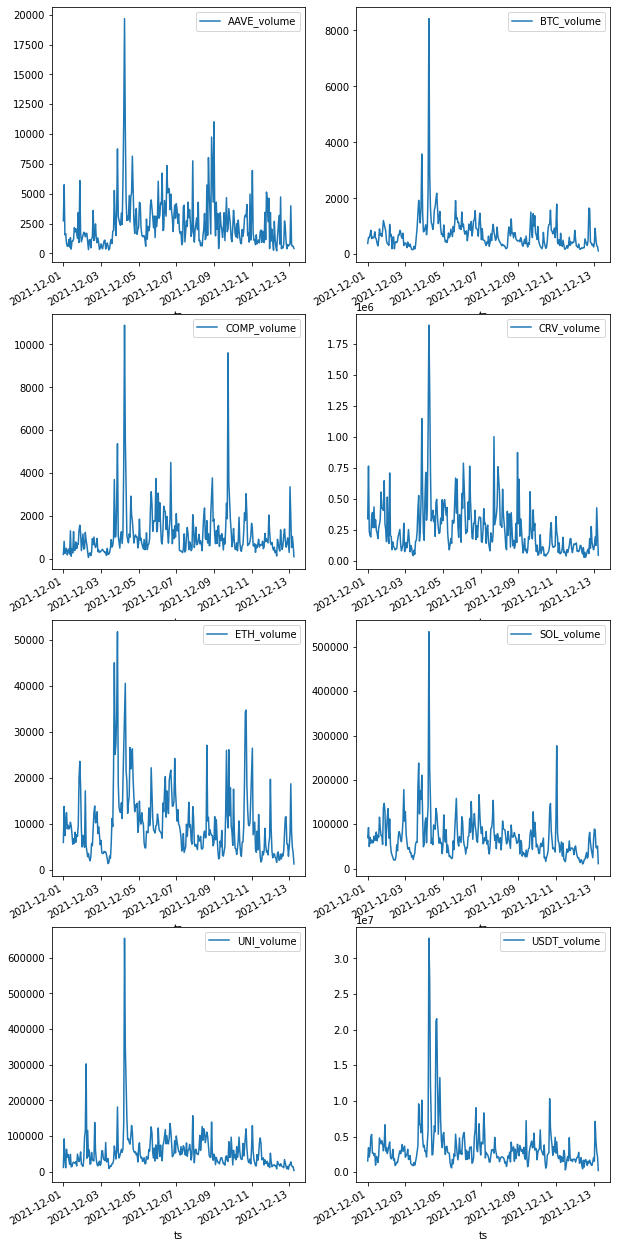

In [20]:
create_graphs(df, 'volume')

## Calculating VolumeUSD

In [21]:
df['volumeUSD'] = df['close'] * df['volume']

In [22]:
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-02 14:00:00,22.4150,22.4913,22.0816,22.3516,31502.151631,7.041235e+05,UNI,ETH
2021-12-02 23:00:00,4.8043,4.8043,4.7426,4.7806,73686.230000,3.522644e+05,CRV,ETH
2021-12-10 15:00:00,182.4900,NaN,175.2100,175.8600,73736.747000,1.296734e+07,SOL,SOL
2021-12-10 18:00:00,3978.4300,3989.7400,3932.0000,3972.3400,18508.040102,7.352023e+07,ETH,ETH
2021-12-08 21:00:00,193.3240,194.2420,192.5640,193.1540,69426.909000,1.341009e+07,SOL,SOL


In [23]:
df.describe()

,open,high,low,close,volume,volumeUSD
count,2316.000000,1899.000000,2073.000000,2316.000000,2.316000e+03,2.316000e+03
mean,7015.341339,6962.182137,6929.452911,7011.425336,4.686998e+05,1.243461e+07
std,16793.950292,16804.801334,16624.026664,16784.235789,1.612668e+06,2.284128e+07
min,1.000200,1.000400,1.000200,1.000300,6.717800e+01,1.819785e+04
25%,15.285000,5.016950,5.253700,15.295000,1.328184e+03,4.595916e+05
50%,190.550500,192.373000,187.924000,190.410500,1.758240e+04,1.814023e+06
75%,1182.302500,284.685000,3830.000000,1182.505000,1.053400e+05,1.578161e+07
max,58664.400000,58783.160000,58445.530000,58664.400000,3.282850e+07,4.029028e+08


## Exploring

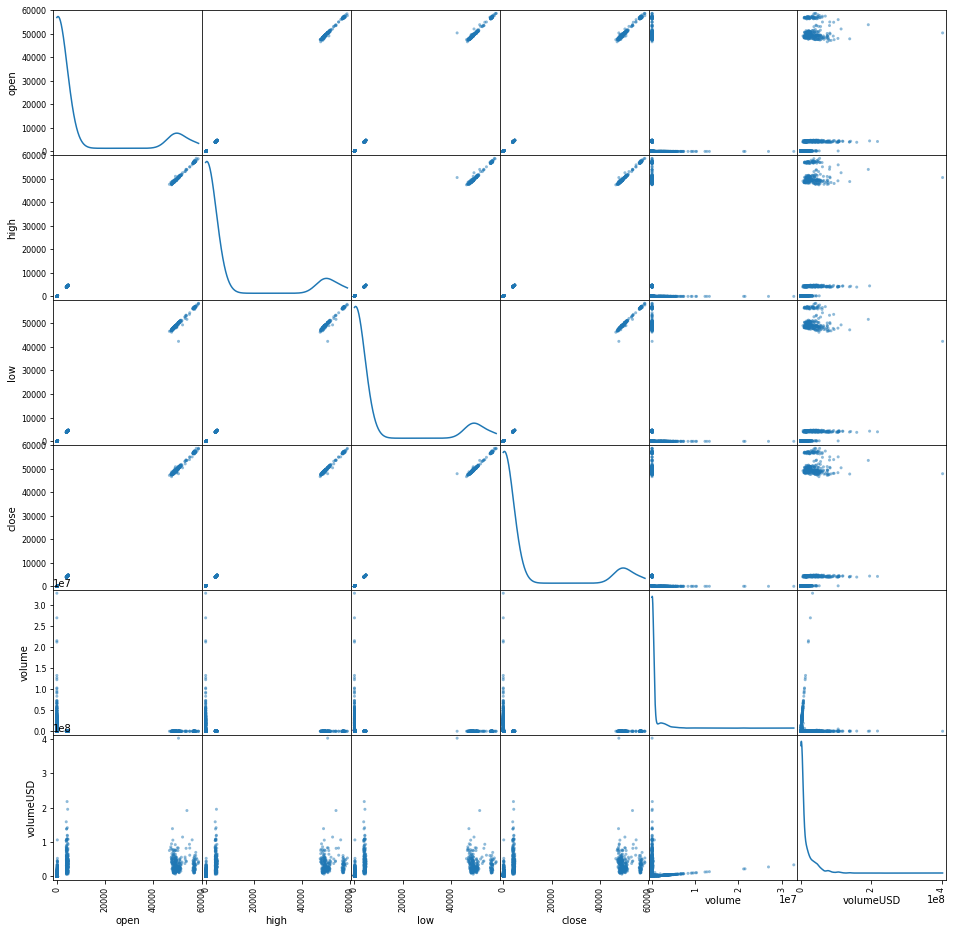

In [25]:
scatter_matrix(df, diagonal='density', figsize=(16,16));

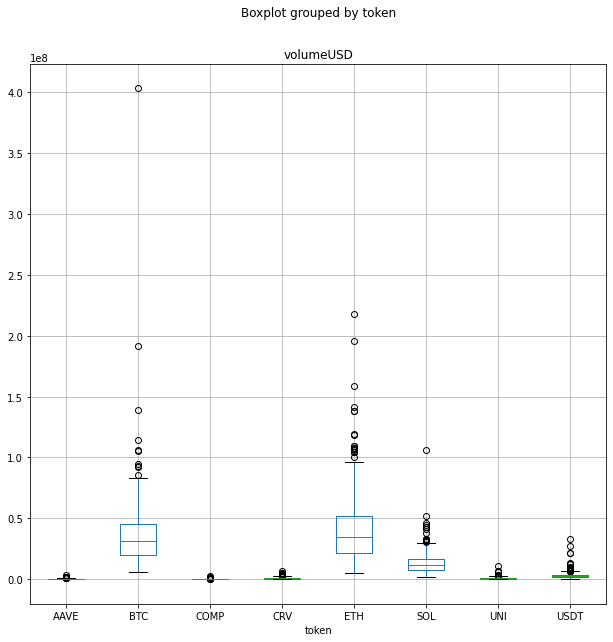

In [32]:
df.boxplot(column='volumeUSD', by='token', figsize=(10,10));